In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv


In [2]:
import pandas as pd
dataset=pd.read_csv("/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv")

In [3]:
dataset


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [4]:
dataset=dataset.drop(["Unnamed: 0"],axis=1)

In [5]:
dataset


,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,ham,Subject: industrial worksheets for august 2000...,0


<Axes: xlabel='label', ylabel='count'>

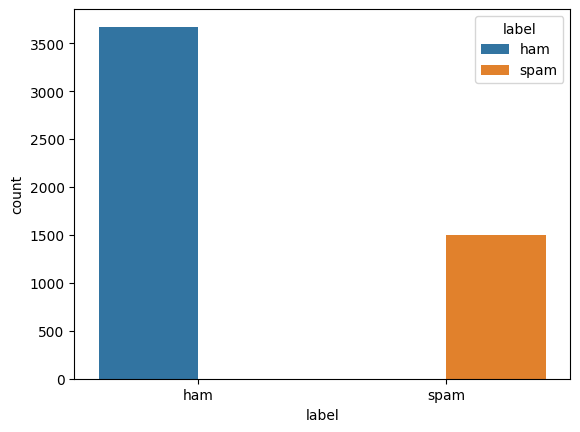

In [6]:
import seaborn as sns
sns.countplot(x="label",data=dataset,hue="label")

In [7]:
corpus=dataset["text"]
corpus

0       Subject: enron methanol ; meter # : 988291\r\n...
1       Subject: hpl nom for january 9 , 2001\r\n( see...
2       Subject: neon retreat\r\nho ho ho , we ' re ar...
3       Subject: photoshop , windows , office . cheap ...
4       Subject: re : indian springs\r\nthis deal is t...
                              ...                        
5166    Subject: put the 10 on the ft\r\nthe transport...
5167    Subject: 3 / 4 / 2000 and following noms\r\nhp...
5168    Subject: calpine daily gas nomination\r\n>\r\n...
5169    Subject: industrial worksheets for august 2000...
5170    Subject: important online banking alert\r\ndea...
Name: text, Length: 5171, dtype: object

In [8]:
ham_df = dataset[dataset['label'] == 'ham']
spam_df = dataset[dataset['label'] == 'spam']

In [9]:
from sklearn.utils import resample

# Oversample the spam class (repeat samples)
spam_oversampled_df = resample(spam_df, 
                               replace=True,    # Sample with replacement
                               n_samples=len(ham_df),  # Match the number of ham samples
                               random_state=42)  # Set a random seed for reproducibility

# Combine the oversampled spam with the original ham
df_balanced = pd.concat([ham_df, spam_oversampled_df])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new distribution
print(df_balanced['label'].value_counts())

label
spam    3672
ham     3672
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

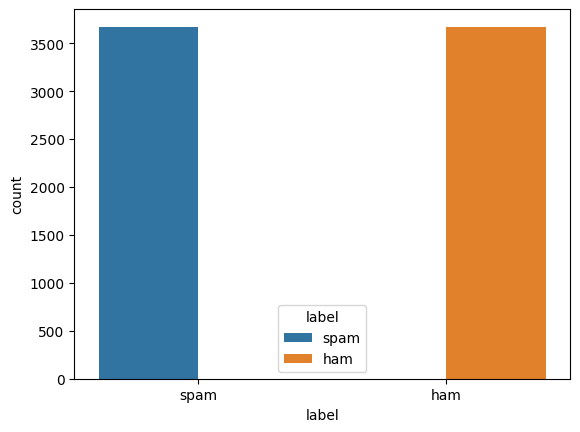

In [10]:

sns.dark_palette(color='black')
sns.countplot(x="label",data=df_balanced,hue="label")

In [11]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# Define a function for text cleaning
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

# Apply cleaning to all emails
mail = df_balanced["text"].apply(clean_text)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
token=Tokenizer()

In [14]:
token.fit_on_texts(mail)
input_data=token.texts_to_sequences(mail)


In [15]:
max_sequence_length = 1
padded=pad_sequences(input_data,maxlen=max_sequence_length,padding='post')

In [16]:
x=padded
y=df_balanced["label_num"]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=42,shuffle=False)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,GRU
import tensorflow_text
from tensorflow.keras.layers import Embedding


In [18]:
size=len(token.word_index)+1
size

47900

In [19]:
model=Sequential()
model.add(Embedding(input_dim=size,output_dim=128,))
model.add(GRU(units=128,return_sequences=True))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
pred_model=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_test,y_test))

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7446 - loss: 0.4979 - val_accuracy: 0.9061 - val_loss: 0.2070
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9619 - loss: 0.1232 - val_accuracy: 0.9101 - val_loss: 0.1943
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9624 - loss: 0.1052 - val_accuracy: 0.9115 - val_loss: 0.1936
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9638 - loss: 0.0978 - val_accuracy: 0.9033 - val_loss: 0.1907
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9661 - loss: 0.0844 - val_accuracy: 0.9033 - val_loss: 0.1966
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9656 - loss: 0.0821 - val_accuracy: 0.9061 - val_loss: 0.2034
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9694 - loss: 0.0749 - val_accuracy: 0.9006 - val_loss: 0.1963
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9627 - loss: 0.0805 - val_accuracy: 0.

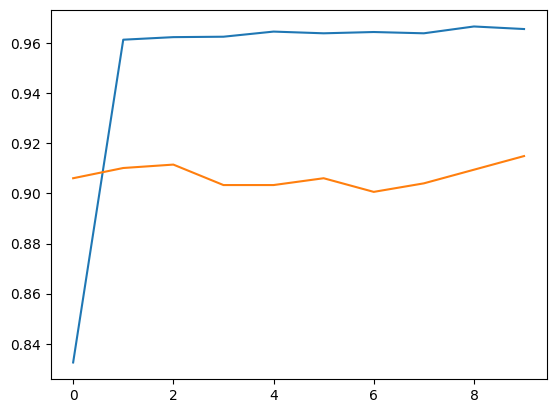

In [22]:
import matplotlib.pyplot as plt
plt.plot(pred_model.history["accuracy"])
plt.plot(pred_model.history["val_accuracy"])

In [23]:
from sklearn.metrics import f1_score,confusion_matrix

In [26]:
y_predict=model.predict(x_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [27]:
y_predict

array([[[2.4190142e-06]],

       [[9.9987221e-01]],

       [[9.9994528e-01]],

       ...,

       [[9.9977165e-01]],

       [[4.8600920e-02]],

       [[8.6357051e-01]]], dtype=float32)

In [41]:
for i in range (0,len(y_predict)):
    if(y_predict[i][0]< 0.5):
        y_predict[i][0]=0
    else:
        y_predict[i][0]=1
        
        

In [42]:
y_predict

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [30]:
y_predict=y_predict.reshape(-1,1)

In [31]:
y_predict

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [32]:
f1=f1_score(y_test,y_predict)

In [33]:
f1

0.9170537491705375

In [34]:
confusion=confusion_matrix(y_test,y_predict)

<Axes: >

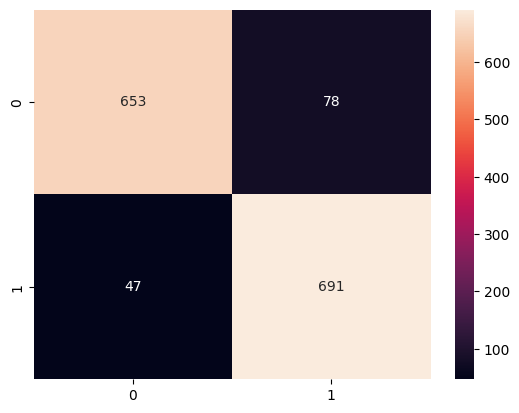

In [35]:
import seaborn as sns
sns.heatmap(confusion,annot=True,fmt='d')

In [63]:

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# Define a function for text cleaning
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

# Apply cleaning to all emails
mail="""
Hey Murtaza S M,

I will share a quick story with you.

A few years ago, I was working with a business owner named Ramesh.

He had this one employee - Ajay (all names changed).

Ajay was the kind of person every business owner dreams of...

super loyal, always on time, and ready to help with anything.

So, when Ramesh needed a manager, his obvious choice was Ajay!

“Ajay has been with me for so many years. He deserves it.", thought Ramesh.

But six months later…

Ramesh regretted it.

The team was missing targets, continuously.

Clients were unhappy, more often than not.

And somehow, every problem was ending up back on Ramesh’s desk.

So what went wrong?

Ajay was loyal - no doubt about that!

But does loyalty alone make someone a leader?

The answer is NO!

And honestly... this is a mistake so many business owners make.

They promote someone because of emotion - “He’s been with me for so long” - instead of asking:

“Is this person ready to lead?”

The truth is:

When the wrong person is in a leadership role, your team struggles, your business slows down, and YOU end up doing all the hard work.

This is exactly what Ramesh learned.

Here’s how he fixed it:

1. He built a system to choose leaders.

No more guesswork. He created a clear process to find the right people for leadership roles, based on performance.

2. He trained the team to take ownership.

Ramesh’s team was taught how to take charge of their work and solve problems on their own.

3. he created a culture of accountability.

Ramesh made it clear: if you’re in charge of something, you’re responsible for the outcome. No excuses.

And what happened?

The team started performing.

Clients were happy.

And for the first time in years, Ramesh wasn’t constantly putting out fires.

Murtaza S M, if you’ve ever felt like you’re carrying your entire business on your shoulders, this is for you.

I’ve put together a free 40-minute training where I show you exactly how to:

- Build a team that takes responsibility and delivers results.

- Spot the right people for leadership roles.

- Create a business that doesn’t depend on you for everything."""
clean=clean_text(mail)
tok=token.fit_on_texts(clean)
input_data=token.texts_to_sequences(clean)
max_sequence_length = 1
padded=pad_sequences(input_data,maxlen=max_sequence_length,padding='post')
pred=model.predict(padded)[1][0]

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [64]:
pred

array([0.9999919], dtype=float32)

In [65]:
if (pred>0.5):
 {
    print("spam")
 }
else:
 {
    print("ham")
 }

spam
